In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP.featurizing import graph_dict
from AttentiveFP.AttentiveLayers_new3 import Fingerprint, graph_dataset, null_collate, Graph, Logger, time_to_str



In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

if cuda_aviable:
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999


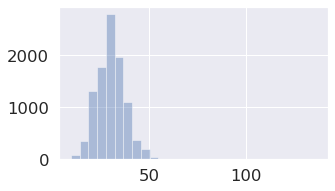

In [4]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "../data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
random_seed = 888 # 69，103, 107
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 300
epochs = 200

p_dropout= 0.3
fingerprint_dim = 32

weight_decay = 6 # also known as l2_regularization_lambda
learning_rate = 3.5
K = 3
T = 2
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/malaria-processed.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    

In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K, T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

97318
preprocess.0.linear.weight torch.Size([32, 39])
preprocess.0.linear.bias torch.Size([32])
preprocess.0.bn.weight torch.Size([32])
preprocess.0.bn.bias torch.Size([32])
propagate.0.encoder.0.linear.weight torch.Size([1024, 10])
propagate.0.encoder.0.linear.bias torch.Size([1024])
propagate.0.encoder.0.bn.weight torch.Size([1024])
propagate.0.encoder.0.bn.bias torch.Size([1024])
propagate.0.align.weight torch.Size([1, 64])
propagate.0.align.bias torch.Size([1])
propagate.0.attend.linear.weight torch.Size([32, 32])
propagate.0.attend.linear.bias torch.Size([32])
propagate.0.attend.bn.weight torch.Size([32])
propagate.0.attend.bn.bias torch.Size([32])
propagate.0.gru.weight_ih torch.Size([96, 32])
propagate.0.gru.weight_hh torch.Size([96, 32])
propagate.0.gru.bias_ih torch.Size([96])
propagate.0.gru.bias_hh torch.Size([96])
propagate.1.encoder.0.linear.weight torch.Size([1024, 10])
propagate.1.encoder.0.linear.bias torch.Size([1024])
propagate.1.encoder.0.bn.weight torch.Size([1024])

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [10]:

log = Logger()
log.open(f'{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train MSE |  valid MSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K, T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_MSE"] = 9e8
    best_param["valid_MSE"] = 9e8
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))
        
        if train_MSE < best_param["train_MSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_MSE"] = train_MSE
        if valid_MSE < best_param["valid_MSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_MSE"] = valid_MSE
            if valid_MSE < 0.8:
                 torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train_MSE | valid MSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"]))
    
    

epoch | loss | train MSE |  valid MSE |  time 
  0   | 1.5059  | 1.6003  | 1.6444  |  0 hr 00 min 
  1   | 1.3872  | 1.3276  | 1.4135  |  0 hr 00 min 
  2   | 1.3302  | 1.2506  | 1.3761  |  0 hr 00 min 
  3   | 1.2825  | 1.2332  | 1.3618  |  0 hr 00 min 
  4   | 1.2709  | 1.2098  | 1.3449  |  0 hr 00 min 
  5   | 1.2463  | 1.1949  | 1.3327  |  0 hr 00 min 
  6   | 1.2369  | 1.1878  | 1.3229  |  0 hr 00 min 
  7   | 1.2314  | 1.1702  | 1.3201  |  0 hr 00 min 
  8   | 1.2089  | 1.1614  | 1.3144  |  0 hr 00 min 
  9   | 1.2006  | 1.1444  | 1.2998  |  0 hr 00 min 
 10   | 1.1853  | 1.1368  | 1.2892  |  0 hr 00 min 
 11   | 1.1816  | 1.1222  | 1.2788  |  0 hr 00 min 
 12   | 1.1773  | 1.1218  | 1.2788  |  0 hr 01 min 
 13   | 1.1677  | 1.1077  | 1.2694  |  0 hr 01 min 
 14   | 1.1622  | 1.1057  | 1.2745  |  0 hr 01 min 
 15   | 1.1576  | 1.0990  | 1.2738  |  0 hr 01 min 
 16   | 1.1459  | 1.0916  | 1.2608  |  0 hr 01 min 
 17   | 1.1486  | 1.0894  | 1.2517  |  0 hr 01 min 
 18   | 1.1346  |

 157  | 0.7310  | 0.6108  | 1.2321  |  0 hr 12 min 
 158  | 0.7217  | 0.6155  | 1.2300  |  0 hr 12 min 
 159  | 0.7218  | 0.6223  | 1.2344  |  0 hr 12 min 
 160  | 0.7195  | 0.6076  | 1.2516  |  0 hr 12 min 
 161  | 0.7234  | 0.6056  | 1.2327  |  0 hr 12 min 
 162  | 0.7307  | 0.6041  | 1.2392  |  0 hr 12 min 
 163  | 0.7215  | 0.6258  | 1.2638  |  0 hr 13 min 
 164  | 0.7185  | 0.6005  | 1.2366  |  0 hr 13 min 
 165  | 0.7063  | 0.6056  | 1.2426  |  0 hr 13 min 
 166  | 0.7207  | 0.5970  | 1.2244  |  0 hr 13 min 
 167  | 0.7137  | 0.5942  | 1.2477  |  0 hr 13 min 
 168  | 0.7085  | 0.5927  | 1.2248  |  0 hr 13 min 
 169  | 0.7181  | 0.5877  | 1.2414  |  0 hr 13 min 
 170  | 0.7065  | 0.5894  | 1.2494  |  0 hr 13 min 
 171  | 0.7180  | 0.5917  | 1.2465  |  0 hr 13 min 
 172  | 0.6916  | 0.5908  | 1.2624  |  0 hr 13 min 
 173  | 0.7081  | 0.5938  | 1.2787  |  0 hr 13 min 
 174  | 0.7025  | 0.5764  | 1.2473  |  0 hr 13 min 
 175  | 0.6997  | 0.5890  | 1.2492  |  0 hr 13 min 
 176  | 0.68

 315  | 0.5042  | 0.3789  | 1.3612  |  0 hr 25 min 
 316  | 0.5159  | 0.3724  | 1.3281  |  0 hr 25 min 
 317  | 0.5095  | 0.3827  | 1.3904  |  0 hr 25 min 
 318  | 0.5084  | 0.3728  | 1.3321  |  0 hr 25 min 
 319  | 0.5080  | 0.3727  | 1.3765  |  0 hr 25 min 
 320  | 0.5042  | 0.3729  | 1.3824  |  0 hr 25 min 
 321  | 0.4911  | 0.3785  | 1.3564  |  0 hr 25 min 
 322  | 0.5058  | 0.3681  | 1.3367  |  0 hr 25 min 
 323  | 0.4986  | 0.3667  | 1.3453  |  0 hr 26 min 
 324  | 0.5047  | 0.3641  | 1.3673  |  0 hr 26 min 
 325  | 0.4935  | 0.3673  | 1.3658  |  0 hr 26 min 
 326  | 0.5082  | 0.3633  | 1.3483  |  0 hr 26 min 
 327  | 0.4860  | 0.3639  | 1.3640  |  0 hr 26 min 
 328  | 0.4890  | 0.3595  | 1.3794  |  0 hr 26 min 
 329  | 0.4922  | 0.3593  | 1.3587  |  0 hr 26 min 
 330  | 0.4840  | 0.3560  | 1.3400  |  0 hr 26 min 
 331  | 0.4969  | 0.3792  | 1.3991  |  0 hr 26 min 
 332  | 0.4952  | 0.3671  | 1.3573  |  0 hr 26 min 
 333  | 0.4907  | 0.3520  | 1.3476  |  0 hr 26 min 
 334  | 0.49

 41   | 1.0767  | 0.9998  | 1.0672  |  0 hr 39 min 
 42   | 1.0695  | 0.9951  | 1.0648  |  0 hr 39 min 
 43   | 1.0603  | 0.9906  | 1.0655  |  0 hr 39 min 
 44   | 1.0630  | 0.9865  | 1.0706  |  0 hr 39 min 
 45   | 1.0612  | 0.9871  | 1.0693  |  0 hr 39 min 
 46   | 1.0511  | 0.9792  | 1.0498  |  0 hr 39 min 
 47   | 1.0515  | 0.9836  | 1.0787  |  0 hr 39 min 
 48   | 1.0486  | 0.9724  | 1.0545  |  0 hr 39 min 
 49   | 1.0483  | 0.9697  | 1.0458  |  0 hr 39 min 
 50   | 1.0340  | 0.9671  | 1.0537  |  0 hr 39 min 
 51   | 1.0171  | 0.9657  | 1.0794  |  0 hr 40 min 
 52   | 1.0355  | 0.9597  | 1.0539  |  0 hr 40 min 
 53   | 1.0179  | 0.9569  | 1.0688  |  0 hr 40 min 
 54   | 1.0276  | 0.9496  | 1.0662  |  0 hr 40 min 
 55   | 1.0237  | 0.9452  | 1.0707  |  0 hr 40 min 
 56   | 1.0196  | 0.9456  | 1.0658  |  0 hr 40 min 
 57   | 1.0237  | 0.9370  | 1.0407  |  0 hr 40 min 
 58   | 1.0087  | 0.9332  | 1.0474  |  0 hr 40 min 
 59   | 1.0054  | 0.9270  | 1.0464  |  0 hr 40 min 
 60   | 0.99

 199  | 0.6844  | 0.5616  | 1.0860  |  0 hr 52 min 
 200  | 0.6918  | 0.5579  | 1.0963  |  0 hr 53 min 
 201  | 0.6871  | 0.5571  | 1.0772  |  0 hr 53 min 
 202  | 0.6875  | 0.5694  | 1.1196  |  0 hr 53 min 
 203  | 0.6796  | 0.5650  | 1.0901  |  0 hr 53 min 
 204  | 0.6774  | 0.5592  | 1.1020  |  0 hr 53 min 
 205  | 0.6837  | 0.5540  | 1.0880  |  0 hr 53 min 
 206  | 0.6836  | 0.5541  | 1.0928  |  0 hr 53 min 
 207  | 0.6731  | 0.5540  | 1.1096  |  0 hr 53 min 
 208  | 0.6816  | 0.5497  | 1.0957  |  0 hr 53 min 
 209  | 0.6753  | 0.5492  | 1.0937  |  0 hr 53 min 
 210  | 0.6784  | 0.5518  | 1.1001  |  0 hr 53 min 
 211  | 0.6829  | 0.5482  | 1.0902  |  0 hr 54 min 
 212  | 0.6666  | 0.5452  | 1.0905  |  0 hr 54 min 
 213  | 0.6608  | 0.5432  | 1.0881  |  0 hr 54 min 
 214  | 0.6580  | 0.5465  | 1.1130  |  0 hr 54 min 
 215  | 0.6579  | 0.5370  | 1.1013  |  0 hr 54 min 
 216  | 0.6581  | 0.5387  | 1.0991  |  0 hr 54 min 
 217  | 0.6600  | 0.5437  | 1.1278  |  0 hr 54 min 
 218  | 0.66

 357  | 0.5017  | 0.3679  | 1.1746  |  1 hr 06 min 
 358  | 0.4979  | 0.3590  | 1.1836  |  1 hr 06 min 
 359  | 0.4964  | 0.3639  | 1.1729  |  1 hr 06 min 
 360  | 0.4917  | 0.3642  | 1.2047  |  1 hr 06 min 
 361  | 0.4985  | 0.3576  | 1.1851  |  1 hr 06 min 
 362  | 0.4862  | 0.3596  | 1.2074  |  1 hr 07 min 
 363  | 0.5010  | 0.3601  | 1.1842  |  1 hr 07 min 
 364  | 0.4897  | 0.3563  | 1.1989  |  1 hr 07 min 
 365  | 0.4874  | 0.3631  | 1.1980  |  1 hr 07 min 
 366  | 0.4837  | 0.3582  | 1.2050  |  1 hr 07 min 
 367  | 0.5019  | 0.3598  | 1.2099  |  1 hr 07 min 
 368  | 0.4895  | 0.3509  | 1.1822  |  1 hr 07 min 
 369  | 0.4884  | 0.3473  | 1.1881  |  1 hr 07 min 
 370  | 0.4844  | 0.3398  | 1.1724  |  1 hr 07 min 
 371  | 0.4703  | 0.3504  | 1.1805  |  1 hr 07 min 
 372  | 0.4715  | 0.3428  | 1.1966  |  1 hr 07 min 
 373  | 0.4858  | 0.3444  | 1.1986  |  1 hr 08 min 
 374  | 0.4791  | 0.3411  | 1.1945  |  1 hr 08 min 
 375  | 0.4785  | 0.3477  | 1.1931  |  1 hr 08 min 
 376  | 0.47

 23   | 1.1036  | 1.0618  | 1.1881  |  1 hr 20 min 
 24   | 1.1090  | 1.0470  | 1.1771  |  1 hr 20 min 
 25   | 1.1065  | 1.0469  | 1.1863  |  1 hr 20 min 
 26   | 1.1030  | 1.0410  | 1.1712  |  1 hr 20 min 
 27   | 1.0969  | 1.0426  | 1.1791  |  1 hr 20 min 
 28   | 1.0972  | 1.0275  | 1.1694  |  1 hr 20 min 
 29   | 1.0850  | 1.0295  | 1.1781  |  1 hr 20 min 
 30   | 1.0711  | 1.0409  | 1.1819  |  1 hr 20 min 
 31   | 1.0749  | 1.0166  | 1.1654  |  1 hr 20 min 
 32   | 1.0754  | 1.0090  | 1.1523  |  1 hr 20 min 
 33   | 1.0725  | 1.0071  | 1.1541  |  1 hr 21 min 
 34   | 1.0595  | 1.0011  | 1.1504  |  1 hr 21 min 
 35   | 1.0531  | 0.9993  | 1.1465  |  1 hr 21 min 
 36   | 1.0490  | 0.9982  | 1.1571  |  1 hr 21 min 
 37   | 1.0548  | 0.9988  | 1.1693  |  1 hr 21 min 
 38   | 1.0641  | 0.9888  | 1.1637  |  1 hr 21 min 
 39   | 1.0358  | 1.0013  | 1.1793  |  1 hr 21 min 
 40   | 1.0477  | 0.9779  | 1.1641  |  1 hr 21 min 
 41   | 1.0424  | 0.9712  | 1.1524  |  1 hr 21 min 
 42   | 1.04

 181  | 0.6810  | 0.5630  | 1.1821  |  1 hr 33 min 
 182  | 0.6914  | 0.5569  | 1.1836  |  1 hr 33 min 
 183  | 0.6800  | 0.5589  | 1.1792  |  1 hr 33 min 
 184  | 0.6651  | 0.5627  | 1.1954  |  1 hr 33 min 
 185  | 0.6823  | 0.5639  | 1.1625  |  1 hr 34 min 
 186  | 0.6849  | 0.5566  | 1.1652  |  1 hr 34 min 
 187  | 0.6812  | 0.5530  | 1.2181  |  1 hr 34 min 
 188  | 0.6794  | 0.5527  | 1.1762  |  1 hr 34 min 
 189  | 0.6718  | 0.5701  | 1.2048  |  1 hr 34 min 
 190  | 0.6710  | 0.5561  | 1.2268  |  1 hr 34 min 
 191  | 0.6675  | 0.5557  | 1.2218  |  1 hr 34 min 
 192  | 0.6579  | 0.5560  | 1.2388  |  1 hr 34 min 
 193  | 0.6715  | 0.5397  | 1.1990  |  1 hr 34 min 
 194  | 0.6559  | 0.5393  | 1.1782  |  1 hr 34 min 
 195  | 0.6533  | 0.5565  | 1.2214  |  1 hr 34 min 
 196  | 0.6619  | 0.5504  | 1.1986  |  1 hr 34 min 
 197  | 0.6517  | 0.5370  | 1.2109  |  1 hr 35 min 
 198  | 0.6537  | 0.5541  | 1.2604  |  1 hr 35 min 
 199  | 0.6675  | 0.5457  | 1.1958  |  1 hr 35 min 
 200  | 0.64

 339  | 0.4876  | 0.3609  | 1.2951  |  1 hr 47 min 
 340  | 0.4919  | 0.3546  | 1.3395  |  1 hr 47 min 
 341  | 0.4861  | 0.3600  | 1.3212  |  1 hr 47 min 
 342  | 0.4881  | 0.3646  | 1.3390  |  1 hr 47 min 
 343  | 0.4860  | 0.3516  | 1.3147  |  1 hr 47 min 
 344  | 0.4793  | 0.3503  | 1.3246  |  1 hr 47 min 
 345  | 0.4857  | 0.3470  | 1.3314  |  1 hr 47 min 
 346  | 0.4814  | 0.3552  | 1.3533  |  1 hr 47 min 
 347  | 0.4746  | 0.3490  | 1.2977  |  1 hr 47 min 
 348  | 0.4791  | 0.3428  | 1.2777  |  1 hr 47 min 
 349  | 0.4775  | 0.3502  | 1.2852  |  1 hr 48 min 
 350  | 0.4798  | 0.3424  | 1.2905  |  1 hr 48 min 
 351  | 0.4722  | 0.3405  | 1.2968  |  1 hr 48 min 
 352  | 0.4712  | 0.3462  | 1.3111  |  1 hr 48 min 
 353  | 0.4693  | 0.3392  | 1.3185  |  1 hr 48 min 
 354  | 0.4833  | 0.3475  | 1.2964  |  1 hr 48 min 
 355  | 0.4725  | 0.3512  | 1.3008  |  1 hr 48 min 
 356  | 0.4727  | 0.3372  | 1.3119  |  1 hr 48 min 
 357  | 0.4706  | 0.3406  | 1.2864  |  1 hr 48 min 
 358  | 0.47

 497  | 0.3751  | 0.2416  | 1.3446  |  2 hr 00 min 
 498  | 0.3635  | 0.2433  | 1.3632  |  2 hr 00 min 
 499  | 0.3773  | 0.2409  | 1.3924  |  2 hr 00 min 
 500  | 0.3605  | 0.2399  | 1.3761  |  2 hr 00 min 
 501  | 0.3768  | 0.2425  | 1.3941  |  2 hr 00 min 
 502  | 0.3690  | 0.2451  | 1.3752  |  2 hr 00 min 
 503  | 0.3640  | 0.2389  | 1.3786  |  2 hr 00 min 
 504  | 0.3686  | 0.2438  | 1.3913  |  2 hr 00 min 
 505  | 0.3666  | 0.2378  | 1.3578  |  2 hr 00 min 
 506  | 0.3538  | 0.2384  | 1.3565  |  2 hr 01 min 
 507  | 0.3803  | 0.2486  | 1.3380  |  2 hr 01 min 
 508  | 0.3709  | 0.2380  | 1.3629  |  2 hr 01 min 
 509  | 0.3651  | 0.2384  | 1.3441  |  2 hr 01 min 
 510  | 0.3666  | 0.2341  | 1.3629  |  2 hr 01 min 
 511  | 0.3646  | 0.2354  | 1.3896  |  2 hr 01 min 
 512  | 0.3733  | 0.2370  | 1.3600  |  2 hr 01 min 
 513  | 0.3543  | 0.2352  | 1.3587  |  2 hr 01 min 
 514  | 0.3552  | 0.2309  | 1.3570  |  2 hr 01 min 
 515  | 0.3719  | 0.2408  | 1.3863  |  2 hr 01 min 
 516  | 0.36

 69   | 0.9705  | 0.8842  | 1.0707  |  2 hr 12 min 
 70   | 0.9752  | 0.8842  | 1.0846  |  2 hr 12 min 
 71   | 0.9690  | 0.8918  | 1.0990  |  2 hr 12 min 
 72   | 0.9559  | 0.8790  | 1.0844  |  2 hr 12 min 
 73   | 0.9511  | 0.8699  | 1.0850  |  2 hr 13 min 
 74   | 0.9677  | 0.8724  | 1.0976  |  2 hr 13 min 
 75   | 0.9510  | 0.8713  | 1.0996  |  2 hr 13 min 
 76   | 0.9453  | 0.8620  | 1.0826  |  2 hr 13 min 
 77   | 0.9368  | 0.8683  | 1.1024  |  2 hr 13 min 
 78   | 0.9370  | 0.8606  | 1.0839  |  2 hr 13 min 
 79   | 0.9343  | 0.8540  | 1.0749  |  2 hr 13 min 
 80   | 0.9420  | 0.8547  | 1.0897  |  2 hr 13 min 
 81   | 0.9393  | 0.8456  | 1.0773  |  2 hr 13 min 
 82   | 0.9234  | 0.8405  | 1.0763  |  2 hr 13 min 
 83   | 0.9339  | 0.8391  | 1.0807  |  2 hr 13 min 
 84   | 0.9262  | 0.8376  | 1.0831  |  2 hr 13 min 
 85   | 0.9149  | 0.8362  | 1.0932  |  2 hr 13 min 
 86   | 0.9267  | 0.8280  | 1.0843  |  2 hr 14 min 
 87   | 0.9103  | 0.8331  | 1.1068  |  2 hr 14 min 
 88   | 0.91

 227  | 0.6648  | 0.5463  | 1.1643  |  2 hr 25 min 
 228  | 0.6518  | 0.5268  | 1.1836  |  2 hr 25 min 
 229  | 0.6507  | 0.5317  | 1.1871  |  2 hr 25 min 
 230  | 0.6517  | 0.5227  | 1.1794  |  2 hr 25 min 
 231  | 0.6472  | 0.5238  | 1.1888  |  2 hr 25 min 
 232  | 0.6420  | 0.5231  | 1.1908  |  2 hr 25 min 
 233  | 0.6464  | 0.5162  | 1.1979  |  2 hr 25 min 
 234  | 0.6564  | 0.5186  | 1.2051  |  2 hr 25 min 
 235  | 0.6401  | 0.5223  | 1.1828  |  2 hr 25 min 
 236  | 0.6401  | 0.5166  | 1.1972  |  2 hr 25 min 
 237  | 0.6481  | 0.5153  | 1.1880  |  2 hr 25 min 
 238  | 0.6430  | 0.5139  | 1.1993  |  2 hr 25 min 
 239  | 0.6409  | 0.5146  | 1.1869  |  2 hr 26 min 
 240  | 0.6330  | 0.5146  | 1.1794  |  2 hr 26 min 
 241  | 0.6336  | 0.5063  | 1.1752  |  2 hr 26 min 
 242  | 0.6480  | 0.4998  | 1.1805  |  2 hr 26 min 
 243  | 0.6296  | 0.5133  | 1.1920  |  2 hr 26 min 
 244  | 0.6443  | 0.5040  | 1.1864  |  2 hr 26 min 
 245  | 0.6340  | 0.5044  | 1.1959  |  2 hr 26 min 
 246  | 0.63

 385  | 0.4839  | 0.3489  | 1.2808  |  2 hr 37 min 
 386  | 0.4879  | 0.3470  | 1.2778  |  2 hr 37 min 
 387  | 0.4814  | 0.3512  | 1.2788  |  2 hr 37 min 
 388  | 0.4835  | 0.3496  | 1.2768  |  2 hr 37 min 
 389  | 0.4838  | 0.3524  | 1.2820  |  2 hr 37 min 
 390  | 0.4863  | 0.3453  | 1.2714  |  2 hr 37 min 
 391  | 0.4871  | 0.3469  | 1.2588  |  2 hr 37 min 
 392  | 0.4834  | 0.3481  | 1.2848  |  2 hr 37 min 
 393  | 0.4852  | 0.3433  | 1.2650  |  2 hr 38 min 
 394  | 0.4763  | 0.3436  | 1.2690  |  2 hr 38 min 
 395  | 0.4705  | 0.3429  | 1.2982  |  2 hr 38 min 
 396  | 0.4842  | 0.3431  | 1.2822  |  2 hr 38 min 
 397  | 0.4746  | 0.3384  | 1.2519  |  2 hr 38 min 
 398  | 0.4943  | 0.3453  | 1.2856  |  2 hr 38 min 
 399  | 0.4800  | 0.3399  | 1.2775  |  2 hr 38 min 
 400  | 0.4934  | 0.3393  | 1.2769  |  2 hr 38 min 
 401  | 0.4682  | 0.3381  | 1.2889  |  2 hr 38 min 
 402  | 0.4683  | 0.3302  | 1.2734  |  2 hr 38 min 
 403  | 0.4782  | 0.3381  | 1.2733  |  2 hr 38 min 
 404  | 0.46

 543  | 0.3838  | 0.2532  | 1.2919  |  2 hr 49 min 
 544  | 0.3848  | 0.2554  | 1.3146  |  2 hr 49 min 
 545  | 0.3706  | 0.2454  | 1.2964  |  2 hr 49 min 
 546  | 0.3742  | 0.2436  | 1.2836  |  2 hr 49 min 
 547  | 0.3741  | 0.2443  | 1.2992  |  2 hr 49 min 
 548  | 0.3847  | 0.2435  | 1.2844  |  2 hr 50 min 
 549  | 0.3787  | 0.2468  | 1.3144  |  2 hr 50 min 
 550  | 0.3762  | 0.2438  | 1.3161  |  2 hr 50 min 
 551  | 0.3718  | 0.2443  | 1.2898  |  2 hr 50 min 
 552  | 0.3862  | 0.2422  | 1.2850  |  2 hr 50 min 
 553  | 0.3788  | 0.2375  | 1.3103  |  2 hr 50 min 
 554  | 0.3732  | 0.2406  | 1.3040  |  2 hr 50 min 
 555  | 0.3717  | 0.2459  | 1.2985  |  2 hr 50 min 
 556  | 0.3703  | 0.2406  | 1.2878  |  2 hr 50 min 
 557  | 0.3810  | 0.2369  | 1.3130  |  2 hr 50 min 
 558  | 0.3832  | 0.2369  | 1.2976  |  2 hr 50 min 
 559  | 0.3852  | 0.2444  | 1.2933  |  2 hr 50 min 
 560  | 0.3787  | 0.2435  | 1.3021  |  2 hr 50 min 
 561  | 0.3748  | 0.2376  | 1.2707  |  2 hr 51 min 
 562  | 0.37

 701  | 0.3085  | 0.1842  | 1.3506  |  3 hr 01 min 
 702  | 0.3108  | 0.1892  | 1.3449  |  3 hr 02 min 
 703  | 0.3109  | 0.1824  | 1.3659  |  3 hr 02 min 
 704  | 0.3109  | 0.1889  | 1.3334  |  3 hr 02 min 
 705  | 0.3102  | 0.1804  | 1.3739  |  3 hr 02 min 
 706  | 0.2968  | 0.1800  | 1.3519  |  3 hr 02 min 
 707  | 0.3041  | 0.1772  | 1.3320  |  3 hr 02 min 
 708  | 0.3069  | 0.1839  | 1.3642  |  3 hr 02 min 
 709  | 0.3072  | 0.1781  | 1.3580  |  3 hr 02 min 
 710  | 0.3003  | 0.1940  | 1.3587  |  3 hr 02 min 
 711  | 0.3026  | 0.1782  | 1.3335  |  3 hr 02 min 
 712  | 0.3071  | 0.1822  | 1.3380  |  3 hr 02 min 
 713  | 0.3078  | 0.1846  | 1.3524  |  3 hr 02 min 
 714  | 0.3109  | 0.1771  | 1.3245  |  3 hr 02 min 
 715  | 0.3090  | 0.1840  | 1.3644  |  3 hr 03 min 
 716  | 0.3049  | 0.1796  | 1.3424  |  3 hr 03 min 
 717  | 0.3122  | 0.1783  | 1.3464  |  3 hr 03 min 
 718  | 0.3039  | 0.1827  | 1.3766  |  3 hr 03 min 
 719  | 0.3008  | 0.1782  | 1.3711  |  3 hr 03 min 
 720  | 0.30

 113  | 0.8265  | 0.7336  | 1.2229  |  3 hr 14 min 
 114  | 0.8433  | 0.7355  | 1.2437  |  3 hr 14 min 
 115  | 0.8288  | 0.7367  | 1.2330  |  3 hr 14 min 
 116  | 0.8432  | 0.7369  | 1.2325  |  3 hr 14 min 
 117  | 0.8195  | 0.7291  | 1.2241  |  3 hr 14 min 
 118  | 0.8194  | 0.7287  | 1.2257  |  3 hr 14 min 
 119  | 0.8247  | 0.7353  | 1.2587  |  3 hr 14 min 
 120  | 0.8258  | 0.7169  | 1.2239  |  3 hr 14 min 
 121  | 0.8190  | 0.7112  | 1.2179  |  3 hr 14 min 
 122  | 0.8201  | 0.7263  | 1.2665  |  3 hr 14 min 
 123  | 0.8280  | 0.7089  | 1.2362  |  3 hr 14 min 
 124  | 0.8178  | 0.7087  | 1.2493  |  3 hr 14 min 
 125  | 0.8095  | 0.7087  | 1.2307  |  3 hr 15 min 
 126  | 0.8076  | 0.7177  | 1.2677  |  3 hr 15 min 
 127  | 0.8082  | 0.7096  | 1.2595  |  3 hr 15 min 
 128  | 0.8046  | 0.6905  | 1.2608  |  3 hr 15 min 
 129  | 0.8069  | 0.6972  | 1.2655  |  3 hr 15 min 
 130  | 0.7928  | 0.7017  | 1.2568  |  3 hr 15 min 
 131  | 0.8027  | 0.6915  | 1.2273  |  3 hr 15 min 
 132  | 0.79

 271  | 0.5769  | 0.4410  | 1.3639  |  3 hr 26 min 
 272  | 0.5764  | 0.4372  | 1.3726  |  3 hr 26 min 
 273  | 0.5701  | 0.4279  | 1.3514  |  3 hr 26 min 
 274  | 0.5599  | 0.4330  | 1.3664  |  3 hr 26 min 
 275  | 0.5622  | 0.4290  | 1.3597  |  3 hr 26 min 
 276  | 0.5673  | 0.4291  | 1.3691  |  3 hr 26 min 
 277  | 0.5606  | 0.4343  | 1.3824  |  3 hr 26 min 
 278  | 0.5649  | 0.4239  | 1.3837  |  3 hr 26 min 
 279  | 0.5660  | 0.4329  | 1.3835  |  3 hr 26 min 
 280  | 0.5597  | 0.4286  | 1.3702  |  3 hr 27 min 
 281  | 0.5619  | 0.4173  | 1.3385  |  3 hr 27 min 
 282  | 0.5507  | 0.4160  | 1.3831  |  3 hr 27 min 
 283  | 0.5557  | 0.4301  | 1.4248  |  3 hr 27 min 
 284  | 0.5528  | 0.4207  | 1.3803  |  3 hr 27 min 
 285  | 0.5519  | 0.4134  | 1.3661  |  3 hr 27 min 
 286  | 0.5532  | 0.4196  | 1.3596  |  3 hr 27 min 
 287  | 0.5493  | 0.4148  | 1.3483  |  3 hr 27 min 
 288  | 0.5490  | 0.4140  | 1.3958  |  3 hr 27 min 
 289  | 0.5440  | 0.4143  | 1.3754  |  3 hr 27 min 
 290  | 0.55

 429  | 0.4367  | 0.2981  | 1.4437  |  3 hr 38 min 
 430  | 0.4226  | 0.2991  | 1.4307  |  3 hr 38 min 
 431  | 0.4311  | 0.2972  | 1.4586  |  3 hr 38 min 
 432  | 0.4408  | 0.2924  | 1.4253  |  3 hr 38 min 
 433  | 0.4256  | 0.2924  | 1.4658  |  3 hr 38 min 
 434  | 0.4234  | 0.2978  | 1.4400  |  3 hr 39 min 
 435  | 0.4240  | 0.2896  | 1.4289  |  3 hr 39 min 
 436  | 0.4343  | 0.2894  | 1.4295  |  3 hr 39 min 
 437  | 0.4268  | 0.2854  | 1.4435  |  3 hr 39 min 
 438  | 0.4178  | 0.2837  | 1.4211  |  3 hr 39 min 
 439  | 0.4253  | 0.2845  | 1.4356  |  3 hr 39 min 
 440  | 0.4140  | 0.2904  | 1.4506  |  3 hr 39 min 
 441  | 0.4224  | 0.2813  | 1.4112  |  3 hr 39 min 
 442  | 0.4120  | 0.2945  | 1.4615  |  3 hr 39 min 
 443  | 0.4111  | 0.2792  | 1.4114  |  3 hr 39 min 
 444  | 0.4246  | 0.2828  | 1.4421  |  3 hr 39 min 
 445  | 0.4109  | 0.2764  | 1.4043  |  3 hr 39 min 
 446  | 0.4183  | 0.2845  | 1.4457  |  3 hr 39 min 
 447  | 0.4140  | 0.2800  | 1.4082  |  3 hr 40 min 
 448  | 0.41

 587  | 0.3363  | 0.2066  | 1.4563  |  3 hr 50 min 
 588  | 0.3464  | 0.2153  | 1.4606  |  3 hr 50 min 
 589  | 0.3450  | 0.2062  | 1.4434  |  3 hr 51 min 
 590  | 0.3456  | 0.2104  | 1.4752  |  3 hr 51 min 
 591  | 0.3406  | 0.2156  | 1.4814  |  3 hr 51 min 
 592  | 0.3418  | 0.2113  | 1.4651  |  3 hr 51 min 
 593  | 0.3403  | 0.2089  | 1.4570  |  3 hr 51 min 
 594  | 0.3372  | 0.2048  | 1.4869  |  3 hr 51 min 
 595  | 0.3313  | 0.2033  | 1.4430  |  3 hr 51 min 
 596  | 0.3348  | 0.2055  | 1.4487  |  3 hr 51 min 
 597  | 0.3415  | 0.2015  | 1.4531  |  3 hr 51 min 
 598  | 0.3360  | 0.2062  | 1.4569  |  3 hr 51 min 
 599  | 0.3496  | 0.2041  | 1.4480  |  3 hr 51 min 
 600  | 0.3315  | 0.2199  | 1.4784  |  3 hr 51 min 
 601  | 0.3348  | 0.1989  | 1.4427  |  3 hr 51 min 
 602  | 0.3291  | 0.2063  | 1.4720  |  3 hr 52 min 
 603  | 0.3344  | 0.2047  | 1.4345  |  3 hr 52 min 
 604  | 0.3401  | 0.2131  | 1.4769  |  3 hr 52 min 
 605  | 0.3293  | 0.2061  | 1.4799  |  3 hr 52 min 
 606  | 0.32

In [11]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_models/model_malaria-processed_Sat_Aug__3_16-39-01_2019_69.pt'

In [ ]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)